## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_05-08-06-23.csv', firstRow=576, lastRow=582)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_060623_S577-582.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=64s and ended at t=472s; mass=44.305g
This equals a volume of 44.394m; expected was 44.941mL; error is 1.219%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.0003125 g/s^2


<IPython.core.display.Javascript object>


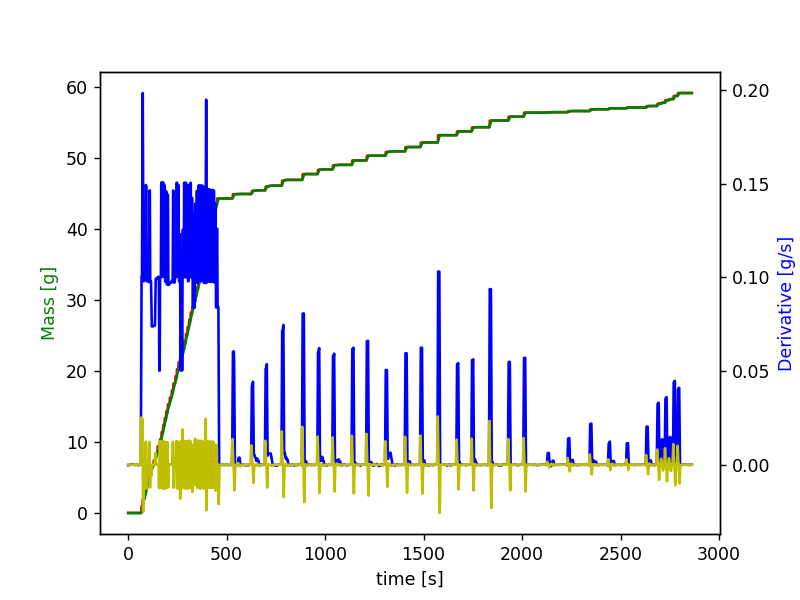

Addition of 0.637g Texapon SB 3 KC detected from 524s to 574s - expected volume = 0.92mL and actual volume = 0.574mL (resulting error is 37.591%)
Addition of 0.525g Plantacare 818 detected from 622s to 668s - expected volume = 0.576mL and actual volume = 0.482mL (resulting error is 16.398%)
Addition of 0.656g Plantacare 818 detected from 692s to 736s - expected volume = 0.576mL and actual volume = 0.602mL (resulting error is 4.494%)
Addition of 0.817g Plantacare 818 detected from 776s to 818s - expected volume = 0.77mL and actual volume = 0.752mL (resulting error is 2.425%)
Addition of 0.822g Dehyton MC detected from 880s to 910s - expected volume = 0.825mL and actual volume = 0.757mL (resulting error is 8.237%)
Addition of 0.665g Dehyton MC detected from 958s to 998s - expected volume = 0.555mL and actual volume = 0.613mL (resulting error is 10.54%)
Addition of 0.64g Dehyton MC detected from 1034s to 1082s - expected volume = 0.555mL and actual volume = 0.59mL (resulting error is 6.41

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.000390625 g/s^2


<IPython.core.display.Javascript object>


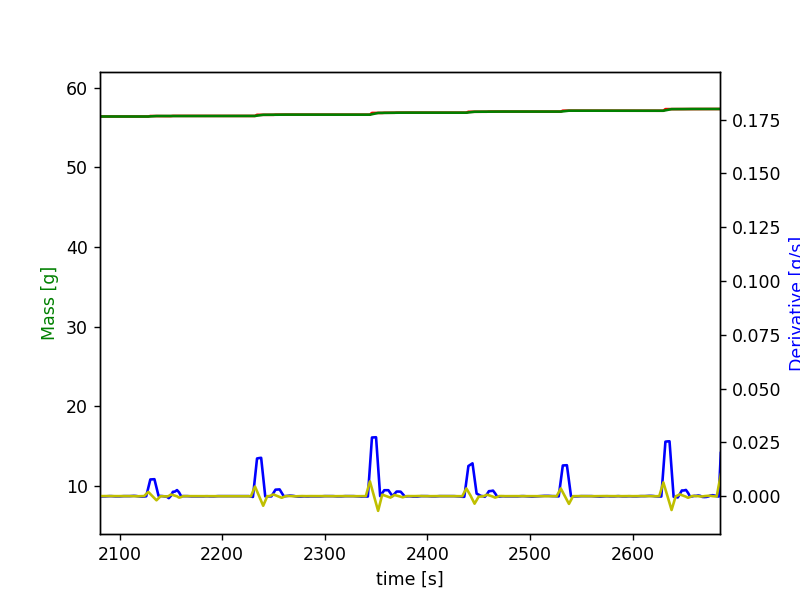

Addition of 0.077g Salcare Super 7 detected from 2124s to 2164s - expected volume = 0.097mL and actual volume = 0.069mL (resulting error is 28.704%)
Addition of 0.163g Salcare Super 7 detected from 2228s to 2264s - expected volume = 0.171mL and actual volume = 0.147mL (resulting error is 14.079%)
Addition of 0.255g Salcare Super 7 detected from 2340s to 2380s - expected volume = 0.236mL and actual volume = 0.227mL (resulting error is 3.994%)
Addition of 0.137g Salcare Super 7 detected from 2434s to 2472s - expected volume = 0.097mL and actual volume = 0.124mL (resulting error is 28.388%)
Addition of 0.113g Salcare Super 7 detected from 2526s to 2544s - expected volume = 0.104mL and actual volume = 0.103mL (resulting error is 1.413%)
Addition of 0.22g Salcare Super 7 detected from 2626s to 2660s - expected volume = 0.22mL and actual volume = 0.199mL (resulting error is 9.465%)


In [5]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=7, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


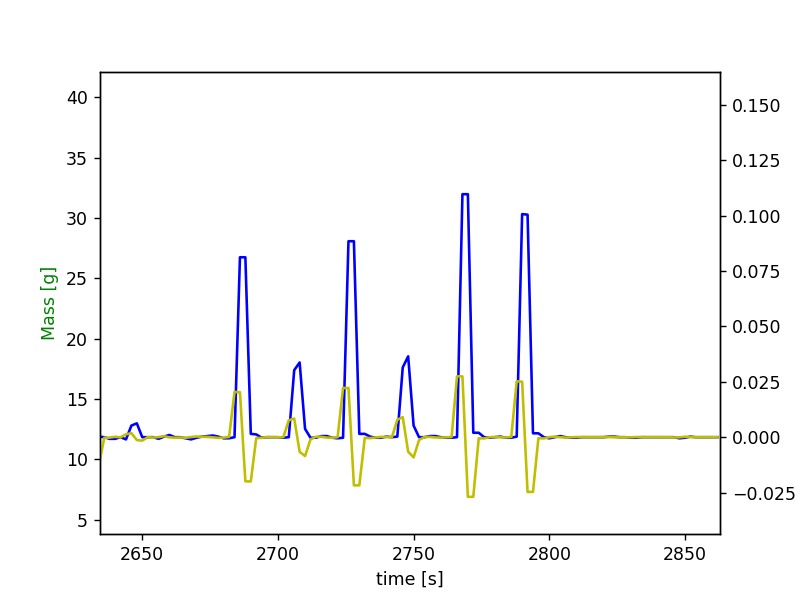

Addition of 0.328g Arlypon F detected from 2682s to 2694s - expected volume = 0.368mL and actual volume = 0.373mL (resulting error is 1.548%)
Addition of 0.134g Arlypon F detected from 2702s to 2714s - expected volume = 0.126mL and actual volume = 0.153mL (resulting error is 20.721%)
Addition of 0.358g Arlypon F detected from 2722s to 2734s - expected volume = 0.395mL and actual volume = 0.402mL (resulting error is 1.847%)
Addition of 0.148g Arlypon F detected from 2742s to 2756s - expected volume = 0.145mL and actual volume = 0.169mL (resulting error is 16.929%)
Addition of 0.446g Arlypon F detected from 2764s to 2776s - expected volume = 0.489mL and actual volume = 0.51mL (resulting error is 4.206%)
Addition of 0.409g Arlypon F detected from 2786s to 2798s - expected volume = 0.432mL and actual volume = 0.468mL (resulting error is 8.488%)


In [6]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [7]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_060623_S577-S582.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_29656\128335913.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
576,577.0,0.000000,0.0,0.0,0.000000,0.0,8.207222,0.000000,0.000000,0.0,12.541417,0.000000,0.00000,0.0,0.0,0.0,0.768616,3.274104,0.0
577,578.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,6.225185,0.0,10.421165,0.000000,0.00000,0.0,0.0,0.0,1.651383,1.355500,0.0
578,579.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,11.386005,11.22134,0.0,0.0,0.0,2.564110,3.599544,0.0
579,580.0,0.000000,0.0,0.0,0.000000,0.0,12.677412,0.000000,0.000000,0.0,0.000000,9.217110,0.00000,0.0,0.0,0.0,1.334528,1.442602,0.0
580,581.0,0.000000,0.0,0.0,11.715242,0.0,0.000000,12.929149,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.125320,4.426839,0.0
581,582.0,6.531239,0.0,0.0,8.371097,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,2.254979,4.192211,0.0
